In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision as vision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.optim import SGD,Adam

### Convolution Network for CIFAR10

In [2]:
# to ensure some reproducibility 
torch.manual_seed(9)

In [3]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.,0.,0.),(1.,1.,1.))])
dataset_train=vision.datasets.CIFAR10(".",download=True,train=True,transform=transform)
dataset_test=vision.datasets.CIFAR10(".",download=True,train=False,transform=transform)
loader_train=DataLoader(dataset_train,batch_size=64,shuffle=True,num_workers=2)
loader_test=DataLoader(dataset_test,batch_size=512,shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
class Net(nn.Module):
  def __init__(self,norm_layers=True):
    super().__init__()
    #self.norm1=nn.BatchNorm2d(32,track_running_stats=False)
    #self.norm2=nn.BatchNorm2d(64,track_running_stats=False)
    self.norm_layers=norm_layers
    self.norm1=nn.BatchNorm2d(32)
    self.norm2=nn.BatchNorm2d(32)
    self.norm3=nn.BatchNorm2d(64)
    self.norm4=nn.BatchNorm2d(64)
    self.relu=nn.ReLU()
    # input is (*,3,32,32)
    self.conv1=nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3)
    # input is (*,32,30,30)
    self.conv2=nn.Conv2d(in_channels=32,out_channels=32,kernel_size=3)
    # input is (*,32,28,28)
    self.pool1=nn.MaxPool2d(kernel_size=(2,2))
    # input is (*,32,14,14)
    self.conv3=nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3)
    # input is (*,64,12,12)
    self.conv4=nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3)
    # input is (*,64,10,10)
    self.pool2=nn.MaxPool2d(kernel_size=(2,2))
    # input is (*,64,5,5)
    self.flatten=nn.Flatten()
    # input is (*,64x5x5)
    self.fc1=nn.Linear(in_features=5*5*64,out_features=128)
    self.fc2=nn.Linear(in_features=128,out_features=10)

  def forward(self,x):
    x=self.conv1(x)
    if self.norm_layers:
      x=self.norm1(x)
    x=self.relu(x)
    x=self.conv2(x)
    if self.norm_layers:
      x=self.norm2(x)
    x=self.relu(x)
    x=self.pool1(x)
    
    x=self.conv3(x)
    if self.norm_layers:
      x=self.norm3(x)
    x=self.relu(x)
    x=self.conv4(x)
    if self.norm_layers:
      x=self.norm4(x)
    x=self.relu(x)
    x=self.pool2(x)
    
    x=self.flatten(x)
    x=self.fc1(x)
    x=self.relu(x)
    x=self.fc2(x)
    return x
    

In [5]:
# use/not use batch normalization
use_BN=True

In [6]:
def get_accuracy(dataloader,model):
  total=len(dataloader.dataset.data)
  correct=0
  for data in dataloader:
    imgs,labels=data
    imgs=imgs.cuda()
    labels=labels.cuda()
    outputs=model(imgs)
  # the second return value is the index of the max i.e. argmax
    _,predicted=torch.max(outputs.data,1)
    correct+=(predicted==labels).sum()
  

  return (correct/total).item()
def accuracy(model,batch):
    imgs,labels=batch
    imgs=imgs.cuda()
    labels=labels.cuda()
    outputs=model(imgs)
    _,pred=torch.max(outputs,dim=1)
    acc=torch.sum(pred==labels).item()
    return torch.tensor(acc/len(labels))
  
@torch.no_grad() 
def evaluate(model,loader):
    model.eval()
    acc=[accuracy(model,batch) for batch in loader]
    acc=torch.stack(acc).mean()
    return acc 

In [7]:
model=Net(norm_layers=use_BN).cuda()
optimizer=Adam(model.parameters())
loss_fn=nn.CrossEntropyLoss()

In [8]:
import datetime
from torch.utils.tensorboard import SummaryWriter
# To display tensorboard inside the notebook
%load_ext tensorboard
current_time = str(datetime.datetime.now().timestamp())
log_dir = 'logs/tensorboard/' + ('with BN-' if use_BN else 'withou BN-')+current_time
writer=SummaryWriter(log_dir)

In [9]:
epochs=100
from tqdm import tqdm
for epoch in range(epochs):
  loop=tqdm(loader_train)
  loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
  epoch_loss=0.
  model.train()
  for (imgs,labels) in loop:
    optimizer.zero_grad()
    imgs=imgs.cuda()
    labels=labels.cuda()
    outputs=model(imgs)
    loss=loss_fn(outputs,labels)
    loss.backward()
    optimizer.step()
    epoch_loss=0.9*epoch_loss+0.1*loss.item()
    loop.set_postfix(loss=epoch_loss)
   
  #acc=get_accuracy(loader_test,model)
  acc=evaluate(model,loader_test)
  writer.add_scalar("loss",epoch_loss,epoch)
  writer.add_scalar("acc",acc,epoch)
writer.close()   

Epoch [100/100]: 100%|██████████| 782/782 [00:04<00:00, 177.78it/s, loss=0.0197] 


In [10]:
%tensorboard --logdir logs/tensorboard

Reusing TensorBoard on port 6006 (pid 323178), started 0:54:00 ago. (Use '!kill 323178' to kill it.)

In [11]:
!pip install torchmetrics
from torchmetrics import ConfusionMatrix
conmat=ConfusionMatrix(num_classes=10)
conmat=conmat.cuda()

Defaulting to user installation because normal site-packages is not writeable


In [12]:
total=0
correct=0
for data in loader_test:
  imgs,labels=data
  imgs=imgs.cuda()
  labels=labels.cuda()
  outputs=model(imgs)
  # the second return value is the index of the max i.e. argmax
  _,predicted=torch.max(outputs.data,1)
  correct+=(predicted==labels).sum()
  total+=labels.size()[0]
  conmat.update(predicted,labels)


<AxesSubplot: >

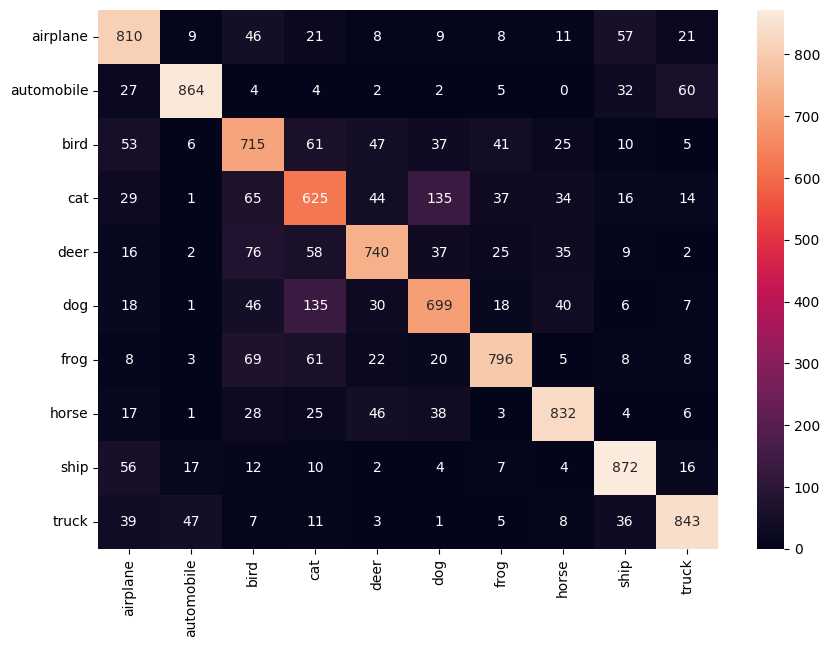

In [13]:
import matplotlib.pyplot as plt
import seaborn as sb
x=conmat.compute().cpu().numpy()
plt.figure(figsize=(10,7))
sb.heatmap(x,xticklabels=dataset_train.classes,yticklabels=dataset_train.classes,annot=True,fmt=".0f")

- The rows are the actual images and the columns are the prediction (How can you check?)
- While the prediction accuracy is good albeit not impressive
- From the confusion matrix we find justifications for the inaccuracies
- For example
    - most of the incorrect classifications of automobiles were classified as trucks
    - most of the incorrect classifications of cats/dogs were classified as dogs/cats
    